# Problem Set - Week 3
### Guillermo Trefogli

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.transformations.series import boxcox
from sktime.forecasting.arima import ARIMA

from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy import stats
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## 1.  Exploratory Data Analysis

- There are 2 variables in the dataset: one measure for time (ds) and 1 float variable: CO2 level. when reading the data, I am setting ds as date by parsing. I am also indexing it already. CO2 is the variable of interest to make predictions.
- There are no missing values
- The ACF tests for CO2 is showing that autocorrelation is present.
- The time series plot for CO2 shows:
    - It is non-stationarity
    - Increasing trend over time
    - Seasonality is present in the trend over time

In [2]:
df = pd.read_csv('hw4_data.csv', parse_dates=['ds'], index_col=['ds'])

In [3]:
df.head()

,co2
ds,
1958-03-15,315.700
1958-04-15,317.450
1958-05-15,317.510
1958-06-15,316.685
1958-07-15,315.860


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 735 entries, 1958-03-15 to 2019-05-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     735 non-null    float64
dtypes: float64(1)
memory usage: 11.5 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co2,735.0,354.210673,27.922811,313.2,328.785,351.34,376.515,414.83


In [6]:
df.isnull().sum()

co2    0
dtype: int64

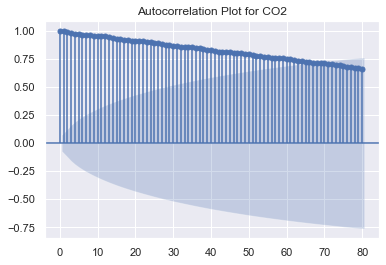

In [7]:
acf_plot_co2= plot_acf(df['co2'], lags=80, title='Autocorrelation Plot for CO2')

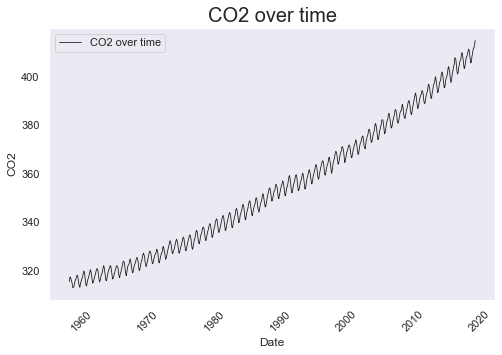

In [8]:
y = df['co2']

plt.figure(figsize=(8,5))  
plt.plot(y, color = 'k',label = "CO2 over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('CO2 over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

## 2. Seasonal ARIMA

### A. Differencing data, ADF, and kpss

- **ADF test** is showing that **non-stationarity cannot be rejected**. The p-value in the test is greater than 0.05, which means that the null hypothesis of non-stationarity cannot be rejected.

- **KPSS test** is showing that **stationarity in the time series can be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of stationarity in the time series can be rejected.

- Based on the two test, we can consider that current time series is not stationary.

- We can differentiate the time series to solve for seasonality and non-seasonality. It is recommended to start with seasonality.

- See statistical and visual analysis below. 

#### Taking logs

In [9]:
bctransformer = boxcox.BoxCoxTransformer()
y_transf = bctransformer.fit_transform(y)

#### Preparing data

In [10]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(y_transf)

#### Testing stationarity

In [11]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

alpha = 0.05

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def kpss_test(timeseries, trend='c'):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)    

#### Statistically

In [12]:
adf_test(y_train)

Results of Dickey-Fuller Test:
Test Statistic                   1.321806
p-value                          0.996728
#Lags Used                      13.000000
Number of Observations Used    537.000000
Critical Value (1%)             -3.442586
Critical Value (5%)             -2.866937
Critical Value (10%)            -2.569645
dtype: float64


In [13]:
kpss_test(y_train)

Results of KPSS Test:
Test Statistic            2.862939
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


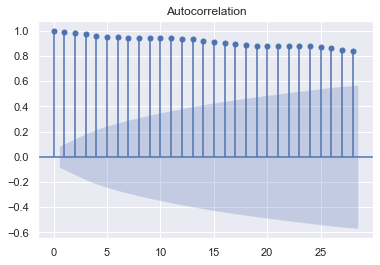

In [14]:
plot_acf(y_train)
plt.show()

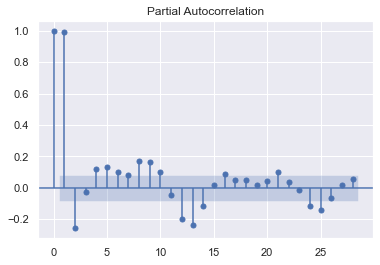

In [15]:
plot_pacf(y_train)
plt.show()

#### Diferentiating for seasonality

In [16]:
y_train_seas = y_train.diff(12).dropna()

In [17]:
adf_test(y_train_seas)

Results of Dickey-Fuller Test:
Test Statistic                  -5.087568
p-value                          0.000015
#Lags Used                      13.000000
Number of Observations Used    525.000000
Critical Value (1%)             -3.442867
Critical Value (5%)             -2.867061
Critical Value (10%)            -2.569710
dtype: float64


In [18]:
kpss_test(y_train_seas)

Results of KPSS Test:
Test Statistic            0.432486
p-value                   0.063153
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


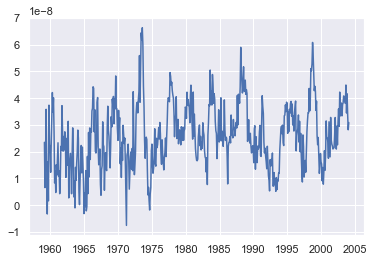

In [19]:
plt.plot(y_train_seas)

### B. Non-seasonality, ACF, PACF 

- After differencing to solve for seasonality, we can test for stationarity again.

- **ADF test** is showing that **non-stationarity cannot be rejected**. The p-value in the test is greater than 0.05, which means that the null hypothesis of non-stationarity cannot be rejected.

- **KPSS test** is showing that **stationarity in the time series cannot be rejected**. The p-value is greater than 0.05, which means that the null hypothesis of stationarity in the time series cannot be rejected.

- Based on the two tests, we cannot consider that current time series is stationary.

- After exploring ACF and PACF test, we can notice that differencing to solve for non-seasonality is needed.

- After differencing to solve for non-seasonality, we verify stationarity using tests again.

- See statistical and visual analysis below. 

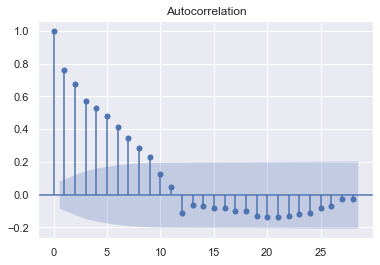

In [20]:
plot_acf(y_train_seas)
plt.show()

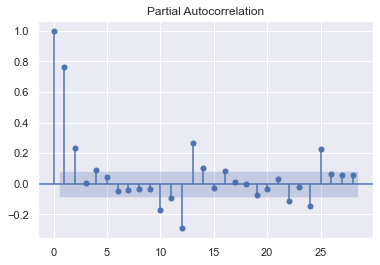

In [21]:
plot_pacf(y_train_seas)
plt.show()

#### Diferentiating for non-seasonality

In [22]:
y_train_non_seas = y_train_seas.diff(12).dropna()

In [23]:
adf_test(y_train_non_seas)

Results of Dickey-Fuller Test:
Test Statistic                -6.193103e+00
p-value                        6.055567e-08
#Lags Used                     1.500000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64


In [24]:
kpss_test(y_train_non_seas)

Results of KPSS Test:
Test Statistic            0.017628
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


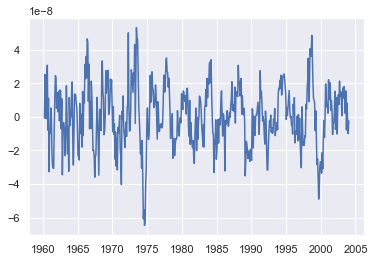

In [25]:
plt.plot(y_train_non_seas)

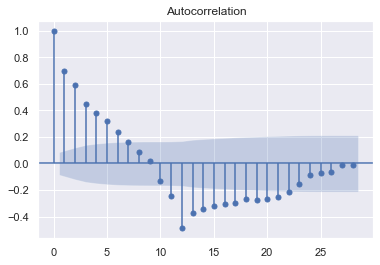

In [26]:
plot_acf(y_train_non_seas)
plt.show()

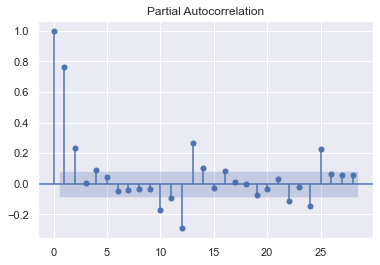

In [27]:
plot_pacf(y_train_seas)
plt.show()

### C. SARIMA

- Both AR L1 and MA L12 are significant.
- Also Ljung-Box test is not significant.
- Then, we can consider this is a good model to make predictions.

In [28]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(1,0,0), seasonal_order=(0, 1, 1, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  551
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                5610.811
Date:                              Thu, 28 Apr 2022   AIC                         -11215.621
Time:                                      15:48:30   BIC                         -11202.752
Sample:                                           0   HQIC                        -11210.588
                                              - 551                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9576   6.84e-20    1.4e+19      0.000       0.958       0.958
ma.S.L12       0.06

### D. Residuals

- Residuals are normal distributed, which is expected.
- Also Ljung-Box test is not significant.

<AxesSubplot:xlabel='ds'>

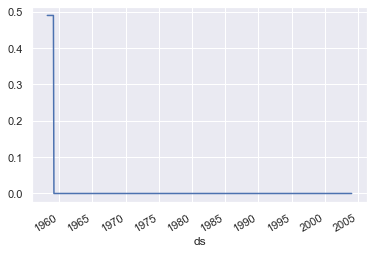

In [29]:
resid = sarima_fit.resid
resid.plot()

#### Exploring drop in the plot

In [30]:
resid=resid[12:]
resid

ds
1959-03-15    2.352108e-08
1959-04-15   -1.561875e-08
1959-05-15    1.023690e-08
1959-06-15    1.934034e-08
1959-07-15   -1.464202e-08
                  ...     
2003-09-15   -7.905610e-09
2003-10-15    7.672949e-09
2003-11-15   -4.974721e-09
2003-12-15   -5.222455e-09
2004-01-15    3.241926e-09
Length: 539, dtype: float64

<AxesSubplot:xlabel='ds'>

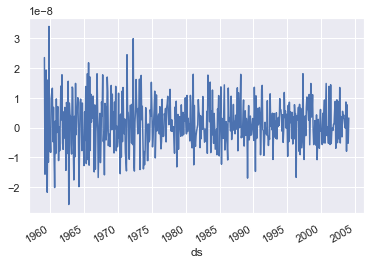

In [31]:
resid.plot()

<AxesSubplot:>

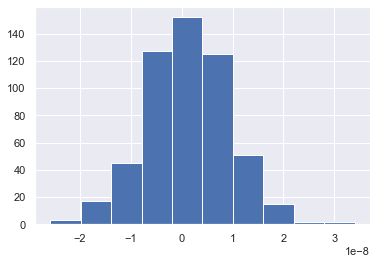

In [32]:
resid.hist()

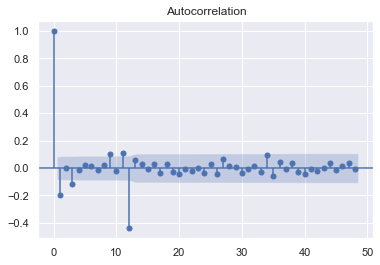

In [33]:
plot_acf(resid, lags=48)
plt.show()

In [34]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,34.294927,0.000165,33.979844,0.000186


### E. Predictions

In [35]:
y_pred=sarima_fit.forecast(steps = len(y_test))

<AxesSubplot:xlabel='ds'>

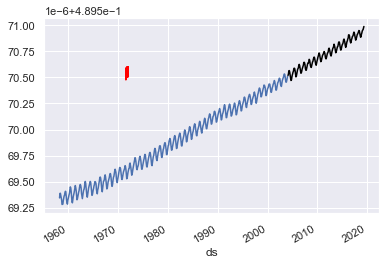

In [36]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [44]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test, y_pred)

3.618575732242834e-07

In [40]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()
mase(y_test, y_pred, y_train=y_train)

8.307318244388691

In [41]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test, y_pred)

1.7715485907157777e-07

In [42]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, y_pred)

4.5610649305011344e-14

In [43]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test, y_pred)

3.618574780786017e-07

## 3 Auto Arima

### A. Fitting the model

In [45]:
from sktime.forecasting.arima import AutoARIMA

In [46]:
autoarima_model = AutoARIMA(D=1, sp=12)
autoarima_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = autoarima_model.predict(fh=fh )

ValueError: Must supply freq for datetime value

In [ ]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

### B. Model summary

In [ ]:
autoarima_model.summary()

### C. Residuals

In [ ]:
from sktime.performance_metrics.forecasting import smape_loss

In [ ]:
smape_loss(y_test, y_pred)

### D. Predictions

### E. SARIMA and AUTOARIMA

#### Contrasting sMAPE

- SARIMA: 
- AUTO ARIMA:

### E. Error metrics

In [ ]:
mae = metrics.mean_absolute_error(y_test['co2'], y_pred)
mae

In [ ]:
mse = metrics.mean_squared_error(y_test['co2'], y_pred)
mse

In [ ]:
rmse = np.sqrt(mse) # or mse**(0.5)
rmse

In [ ]:
r2 = metrics.r2_score(y_test['co2'], y_pred)
r2

## 4. Bonus